In [5]:
!unzip aiad-data.zip -d .

Archive:  aiad-data.zip
   creating: ./aiad-data/
   creating: ./aiad-data/test/
   creating: ./aiad-data/test/images/
  inflating: ./aiad-data/test/images/guatemala-volcano_00000003_post_disaster.png  
  inflating: ./aiad-data/test/images/guatemala-volcano_00000003_pre_disaster.png  
  inflating: ./aiad-data/test/images/guatemala-volcano_00000005_post_disaster.png  
  inflating: ./aiad-data/test/images/guatemala-volcano_00000005_pre_disaster.png  
  inflating: ./aiad-data/test/images/guatemala-volcano_00000009_post_disaster.png  
  inflating: ./aiad-data/test/images/guatemala-volcano_00000009_pre_disaster.png  
   creating: ./aiad-data/test/labels/
  inflating: ./aiad-data/test/labels/guatemala-volcano_00000003_post_disaster.json  
  inflating: ./aiad-data/test/labels/guatemala-volcano_00000003_pre_disaster.json  
  inflating: ./aiad-data/test/labels/guatemala-volcano_00000005_post_disaster.json  
  inflating: ./aiad-data/test/labels/guatemala-volcano_00000005_pre_disaster.json  
  in

In [6]:
!pip install -U ultralytics

In [7]:
!unzip yolo_xbd.zip -d .

Archive:  yolo_xbd.zip
replace ./yolo_xbd/train_pairs.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ./yolo_xbd/train_pairs.csv  
replace ./yolo_xbd/.gitkeep? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
 extracting: ./yolo_xbd/.gitkeep     
replace ./yolo_xbd/xbd6.yaml? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ./yolo_xbd/xbd6.yaml    
replace ./yolo_xbd/val_pairs.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ./yolo_xbd/val_pairs.csv  
replace ./yolo_xbd/images/train/guatemala-volcano_00000000_pre_disaster.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ./yolo_xbd/images/train/guatemala-volcano_00000000_pre_disaster.png  
replace ./__MACOSX/yolo_xbd/images/train/._guatemala-volcano_00000000_pre_disaster.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ./__MACOSX/yolo_xbd/images/train/._guatemala-volcano_00000000_pre_disaster.png  
replace ./yolo_xbd/images/train/guatemala-volcano_00000001_pre_disaster.png? [y]es, [n]o, [A]ll, [N]one, [r]

In [10]:
### MAIN - TRAIN

from pathlib import Path
import torch
import torch.nn as nn
import numpy as np
import cv2
from ultralytics import YOLO
from ultralytics.data.dataset import YOLODataset
import csv

class XBD6ChannelDataset(YOLODataset):
    def __init__(self, *args, pre_post_pairs=None, image_index=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.pre_post_pairs = pre_post_pairs or {}
        self.image_index = image_index or {}
        self.split = kwargs.get('split', 'train')

    def infer_pre_path(self, post_path):
        name = Path(post_path).name
        pre_name = self.pre_post_pairs.get(name)
        candidates = [pre_name] if pre_name else []

        # Heuristic options
        name_variants = [
            name.replace("post_disaster", "pre_disaster"),
            name.replace("_post_", "_pre_"),
            name.replace("-post", "-pre"),
            name.replace("post", "pre")
        ]
        candidates += name_variants

        for cand in candidates:
            if not cand:
                continue
            p = self.image_index.get(cand)
            if p:
                return str(p)
            lc = cand.lower()
            for k, v in self.image_index.items():
                if k.lower() == lc:
                    return str(v)
        return post_path  # fallback: use post as pre

    def __getitem__(self, index):
        sample = super().__getitem__(index)
        post_img = sample['img']            # (3,H,W)
        post_path = sample['im_file']       # str

        # Lookup pre-disaster image
        pre_path = self.infer_pre_path(post_path)
        pre_bgr = cv2.imread(pre_path, cv2.IMREAD_COLOR)
        pre_rgb = cv2.cvtColor(pre_bgr, cv2.COLOR_BGR2RGB)

        H, W = post_img.shape[1:]
        if pre_rgb.shape[:2] != (H, W):
            pre_rgb = cv2.resize(pre_rgb, (W, H), interpolation=cv2.INTER_LINEAR)

        pre_tensor = torch.from_numpy(pre_rgb).permute(2, 0, 1).float() / 255.0  # (3,H,W)
        img6 = torch.cat([pre_tensor, post_img], dim=0)  # (6,H,W)

        sample['img'] = img6
        return sample

def _patch_first_conv_to_6ch(model_nn: nn.Module):
    for name, module in model_nn.named_modules():
        if isinstance(module, nn.Conv2d) and module.in_channels == 3:
            new_conv = nn.Conv2d(
                6, module.out_channels, module.kernel_size,
                stride=module.stride, padding=module.padding, bias=module.bias is not None
            )
            with torch.no_grad():
                new_conv.weight[:, :3] = module.weight
                new_conv.weight[:, 3:] = module.weight
            # Replace in parent
            parent = model_nn
            for part in name.split('.')[:-1]:
                parent = getattr(parent, part)
            setattr(parent, name.split('.')[-1], new_conv)
            print(f"✅ Patched conv '{name}' to accept 6-channel input.")
            return
    raise RuntimeError("❌ No 3-channel Conv2d layer found to patch.")

# --- Helpers for pre-post pairing ---
def load_pairs(csv_path):
    m = {}
    with open(csv_path) as f:
        for row in csv.DictReader(f):
            post, pre = row["post_img"].strip(), row["pre_img"].strip()
            if post and pre:
                m[post] = pre
    return m

def build_image_index(images_dir: Path):
    exts = {".jpg", ".jpeg", ".png", ".tif", ".tiff"}
    return {p.name: p for p in images_dir.rglob("*") if p.suffix.lower() in exts}

# --- Custom dataset with 6-channel stacking ---
class XBD6ChannelDataset(YOLODataset):
    def __init__(self, *args, pre_post_pairs=None, image_index=None, split='train', **kwargs):
        super().__init__(*args, **kwargs)
        self.pre_post_pairs = pre_post_pairs or {}
        self.image_index = image_index or {}
        self.split = split

    def infer_pre_path(self, post_path):
        name = Path(post_path).name
        pre_name = self.pre_post_pairs.get(name)
        candidates = ([pre_name] if pre_name else []) + [
            name.replace("post_disaster", "pre_disaster"),
            name.replace("_post_", "_pre_"),
            name.replace("-post", "-pre"),
            name.replace("post", "pre")
        ]
        for cand in candidates:
            if not cand: continue
            p = self.image_index.get(cand)
            if p: return str(p)
            for k, v in self.image_index.items():
                if k.lower() == cand.lower(): return str(v)
        return str(post_path)

    def __getitem__(self, index):
        sample = super().__getitem__(index)
        post_img = sample['img']            # Tensor (3,H,W)
        post_path = sample['im_file']       # path string
        pre_path = self.infer_pre_path(post_path)
        pre_bgr = cv2.imread(pre_path, cv2.IMREAD_COLOR)
        pre_rgb = cv2.cvtColor(pre_bgr, cv2.COLOR_BGR2RGB)

        H, W = post_img.shape[1:]
        if pre_rgb.shape[:2] != (H, W):
            pre_rgb = cv2.resize(pre_rgb, (W, H))

        pre_tensor = torch.from_numpy(pre_rgb).permute(2, 0, 1).float() / 255.0
        img6 = torch.cat([pre_tensor, post_img], dim=0)
        sample['img'] = img6
        return sample

# --- Patch model stem to accept 6-channel inputs ---
def patch_first_conv_to_6ch(model_nn: nn.Module):
    for name, module in model_nn.named_modules():
        if isinstance(module, nn.Conv2d) and module.in_channels == 3:
            new_conv = nn.Conv2d(
                6, module.out_channels, module.kernel_size,
                stride=module.stride, padding=module.padding, bias=module.bias is not None
            )
            with torch.no_grad():
                new_conv.weight[:, :3] = module.weight
                new_conv.weight[:, 3:] = module.weight
            parent = model_nn
            for part in name.split('.')[:-1]:
                parent = getattr(parent, part)
            setattr(parent, name.split('.')[-1], new_conv)
            print(f"Patched conv '{name}' for 6-channel input.")
            return
    raise RuntimeError("No 3-channel Conv2d found.")

# --- Load data and model ---
root = Path("yolo_xbd")
train_pairs = load_pairs(root / "train_pairs.csv")
val_pairs   = load_pairs(root / "val_pairs.csv")
train_index = build_image_index(root / "images/train")
val_index   = build_image_index(root / "images/val")

model = YOLO("yolo11m-seg.pt")
patch_first_conv_to_6ch(model.model)

# --- Monkey-patch YOLODataset ---
import ultralytics.data.dataset as dsmod
dsmod.YOLODataset = XBD6ChannelDataset

# --- Train normally ---
model.train(
    data="yolo_xbd/xbd6.yaml",
    epochs=10,
    imgsz=1024,
    batch=8,
    device="cuda" if torch.cuda.is_available() else "cpu",
    seed=42,
    cache=False
)

Patched conv 'model.0.conv' for 6-channel input.
Ultralytics 8.3.179 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=yolo_xbd/xbd6.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1024, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11m-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspecti

Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  1    111872  ultralytics.nn.modules.block.C3k2            [128, 256, 1, True, 0.25]     
  3                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  4                  -1  1    444928  ultralytics.nn.modules.block.C3k2            [256, 512, 1, True, 0.25]     
  5                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512, 512, 3, 2]              


  6                  -1  1   1380352  ultralytics.nn.modules.block.C3k2            [512, 512, 1, True]           
  7                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512, 512, 3, 2]              
  8                  -1  1   1380352  ultralytics.nn.modules.block.C3k2            [512, 512, 1, True]           
  9                  -1  1    656896  ultralytics.nn.modules.block.SPPF            [512, 512, 5]                 
 10                  -1  1    990976  ultralytics.nn.modules.block.C2PSA           [512, 512, 1]                 
 11                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 12             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 13                  -1  1   1642496  ultralytics.nn.modules.block.C3k2            [1024, 512, 1, True]          
 14                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None

AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2393.7±1346.3 MB/s, size: 1627.6 KB)


train: Scanning /content/yolo_xbd/labels/train... 8 images, 4 backgrounds, 0 corrupt: 100%|██████████| 8/8 [00:00<00:00, 284.34it/s]

train: New cache created: /content/yolo_xbd/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2120.0±1556.8 MB/s, size: 1327.5 KB)


val: Scanning /content/yolo_xbd/labels/val... 8 images, 4 backgrounds, 0 corrupt: 100%|██████████| 8/8 [00:00<00:00, 140.28it/s]

val: New cache created: /content/yolo_xbd/labels/val.cache


Plotting labels to runs/segment/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 115 weight(decay=0.0), 126 weight(decay=0.0005), 125 bias(decay=0.0)
Image sizes 1024 train, 1024 val
Using 2 dataloader workers
Logging results to runs/segment/train3
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/10      12.2G      2.681      4.193      5.612        1.4        104       1024: 100%|██████████| 1/1 [00:05<00:00,  5.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]

                   all          8         94    0.00137     0.0577    0.00138   0.000673    0.00137     0.0577    0.00138   0.000454



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/10      12.7G      2.743       3.03      5.665      1.557         86       1024: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]

                   all          8         94    0.00136     0.0577    0.00134   0.000687    0.00136     0.0577    0.00134   0.000438



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/10      12.2G      2.575      3.631      6.134      1.333        110       1024: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.84it/s]

                   all          8         94    0.00135     0.0577    0.00133   0.000659    0.00135     0.0577    0.00133   0.000355



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/10      12.8G      2.664      3.201      5.637      1.596         82       1024: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.88it/s]

                   all          8         94   0.000894     0.0385    0.00103   0.000569   0.000447     0.0192   0.000263   0.000184



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/10      12.7G      2.866      3.601      5.981      1.799         82       1024: 100%|██████████| 1/1 [00:01<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.04it/s]

                   all          8         94   0.000912     0.0385   0.000977    0.00047   0.000456     0.0192   0.000264   0.000184



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/10      12.4G      2.703      3.307      5.796      1.429        104       1024: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]

                   all          8         94   0.000445     0.0192   0.000687   0.000275          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/10      12.8G      2.754      3.188      5.325      1.476        104       1024: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.35it/s]

                   all          8         94   0.000444     0.0192   0.000727   0.000291          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/10      12.3G        2.8      3.947      5.975      1.436        109       1024: 100%|██████████| 1/1 [00:01<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]

                   all          8         94    0.00185     0.0425    0.00142   0.000781    0.00125     0.0233   0.000687   0.000243



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/10      12.7G      2.488      3.038      5.296      1.162        110       1024: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]

                   all          8         94    0.00185     0.0425    0.00142   0.000781    0.00125     0.0233   0.000687   0.000243



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/10      12.1G      2.324      3.179       4.91      1.123        110       1024: 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.33it/s]

                   all          8         94    0.00188     0.0425    0.00147   0.000805    0.00188     0.0425    0.00147   0.000321



10 epochs completed in 0.008 hours.
Optimizer stripped from runs/segment/train3/weights/last.pt, 45.2MB
Optimizer stripped from runs/segment/train3/weights/best.pt, 45.2MB

Validating runs/segment/train3/weights/best.pt...
Ultralytics 8.3.179 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11m-seg summary (fused): 138 layers, 22,338,396 parameters, 0 gradients, 123.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/1 [00:00<?, ?it/s]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


                   all          8         94    0.00188     0.0425    0.00146   0.000798    0.00188     0.0425    0.00146   0.000319
           building_no          3         62    0.00275     0.0161    0.00148   0.000738    0.00275     0.0161    0.00148   0.000148
        building_minor          2         14          0          0          0          0          0          0          0          0
        building_major          2         13    0.00475      0.154    0.00435    0.00245    0.00475      0.154    0.00435    0.00113
    building_destroyed          2          5          0          0          0          0          0          0          0          0
Speed: 1.2ms preprocess, 37.9ms inference, 0.0ms loss, 6.3ms postprocess per image
Results saved to runs/segment/train3


ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f51ee526a50>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0

In [14]:
### MAIN - PREDICT
import cv2
import torch

def stack_pre_post(pre_path, post_path, size=1024):
    pre = cv2.imread(pre_path)
    post = cv2.imread(post_path)

    pre = cv2.cvtColor(pre, cv2.COLOR_BGR2RGB)
    post = cv2.cvtColor(post, cv2.COLOR_BGR2RGB)

    pre = cv2.resize(pre, (size, size))
    post = cv2.resize(post, (size, size))

    pre_t = torch.from_numpy(pre).permute(2, 0, 1).float() / 255.0
    post_t = torch.from_numpy(post).permute(2, 0, 1).float() / 255.0

    img6 = torch.cat([pre_t, post_t], dim=0)  # (6, H, W)
    return img6.unsqueeze(0)  # Add batch dimension: (1, 6, H, W)

# Use the correct train path
model = YOLO("runs/segment/train3/weights/best.pt")  # or last.pt
model.model.eval()

# Important: patch model if not already done
patch_first_conv_to_6ch(model.model)

# Load images and stack
img6 = stack_pre_post("/content/aiad-data/train/images/guatemala-volcano_00000002_pre_disaster.png", "/content/aiad-data/train/images/guatemala-volcano_00000002_post_disaster.png")  # shape: (1, 6, 1024, 1024)

# Move to device
img6 = img6.to(next(model.model.parameters()).device)


# Run prediction
with torch.no_grad():
    results = model.model(img6)

# preds is a list of batch outputs
output = results[0]

# Show masks if available
if hasattr(output, "masks") and output.masks is not None:
    masks = output.masks.data  # shape: (N, H, W)
    print("Number of masks:", masks.shape[0])
    # Optional: visualize masks using matplotlib
else:
    print("No masks detected.")

Patched conv 'model.0.conv' for 6-channel input.
No masks detected.


Patched conv 'model.0.conv' for 6-channel input.


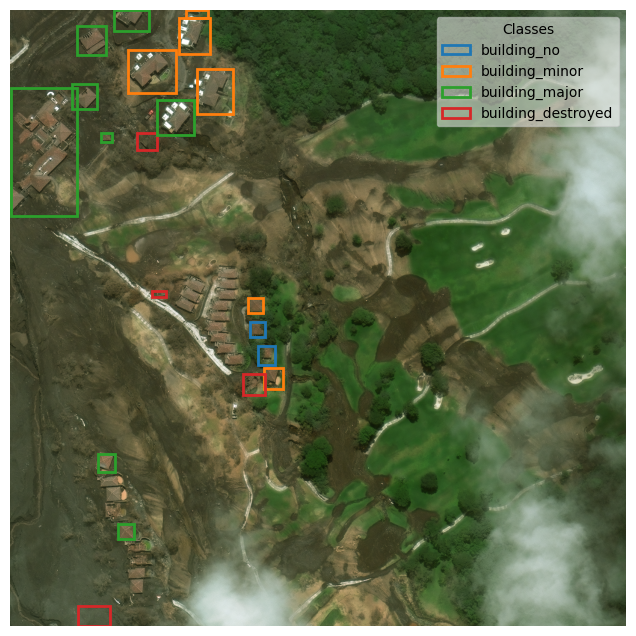

In [32]:
# MAIN - PREDICT + PLOT
import matplotlib.patches as mpatches
from matplotlib import colormaps as cm
from ultralytics.utils.plotting import Colors
import cv2
import torch
from ultralytics import YOLO
from ultralytics.engine.results import Boxes
import matplotlib.pyplot as plt

def stack_pre_post(pre_path, post_path, size=1024):
    pre = cv2.imread(pre_path)
    post = cv2.imread(post_path)

    pre = cv2.cvtColor(pre, cv2.COLOR_BGR2RGB)
    post = cv2.cvtColor(post, cv2.COLOR_BGR2RGB)

    pre = cv2.resize(pre, (size, size))
    post = cv2.resize(post, (size, size))

    pre_t = torch.from_numpy(pre).permute(2, 0, 1).float() / 255.0
    post_t = torch.from_numpy(post).permute(2, 0, 1).float() / 255.0

    img6 = torch.cat([pre_t, post_t], dim=0)  # (6, H, W)
    return img6.unsqueeze(0)  # Add batch dimension: (1, 6, H, W)

# 1. Load your model (patching for 6-ch if you like, but not strictly needed for GT)
model = YOLO("runs/segment/train3/weights/best.pt")
patch_first_conv_to_6ch(model.model)
model.model.eval()

# 2. Paths to one of your val images + its YOLO .txt labels
img_path   = "/content/yolo_xbd/images/val/guatemala-volcano_00000004_post_disaster.png"
label_path = "/content/yolo_xbd/labels/val/guatemala-volcano_00000004_post_disaster.txt"

# 3. Call predict to get a Results object (we’ll overwrite its .boxes)
# results = model.predict(source=[img_path], verbose=False)
# res = results[0]  # a Results object with dummy preds

# 2. Stack your (1,6,H,W) tensor
img6 = stack_pre_post(
    "/content/yolo_xbd/images/val/guatemala-volcano_00000004_pre_disaster.png",
    "/content/yolo_xbd/images/val/guatemala-volcano_00000004_post_disaster.png",
    size=1024
)
device = next(model.model.parameters()).device
img6 = img6.to(device)

# 3. High-level predict (this will do NMS & give you .boxes/.masks)
with torch.no_grad():
    results = model.predict(source=img6, device=device, verbose=False)
res = results[0]  # a Results object

# 4. Read the image (BGR→RGB) and note its size
img_bgr = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
h0, w0 = img_rgb.shape[:2]

# 5. Parse your YOLO-format GT file to absolute [x1,y1,x2,y2,conf,cls]
# 5. Parse polygon labels → bounding boxes
gt_boxes = []
with open(label_path) as f:
    for line in f:
        vals = list(map(float, line.strip().split()))
        cls  = int(vals[0])
        coords = vals[1:]
        # coords = [x1,y1,x2,y2,...]
        xs = coords[0::2]
        ys = coords[1::2]
        x1, x2 = min(xs), max(xs)
        y1, y2 = min(ys), max(ys)
        # x1,y1,x2,y2 are normalized [0,1], so convert:
        x1 *= w0; x2 *= w0
        y1 *= h0; y2 *= h0
        gt_boxes.append([x1, y1, x2, y2, 1.0, cls])

# 1. Choose a distinct color for each class, e.g. from a matplotlib colormap:
#    “tab10” has 10 distinct, colorblind-friendly hues.
cmap = cm.get_cmap("tab10")
# Suppose you have 4 classes (0–3):
custom_colors = { cls: cmap(cls/10)[:3]  # RGB in [0,1]
                  for cls in range(4) }

if not gt_boxes:
    print("No GT boxes found.")
else:

    # 1) prepare figure
    fig, ax = plt.subplots(figsize=(8,8))
    ax.imshow(img_rgb)
    ax.axis("off")

    # 2) get a Colors instance
    colors = Colors()

    # 3) draw each box, color by its class index
    for x1, y1, x2, y2, conf, cls in gt_boxes:
        cls = int(cls)
        color = custom_colors[cls]
        # draw rectangle
        rect = plt.Rectangle(
            (x1, y1), x2 - x1, y2 - y1,
            fill=False, linewidth=2, edgecolor=color
        )
        ax.add_patch(rect)

    # 4) build a legend keyed on class
    unique_cls = sorted({int(b[5]) for b in gt_boxes})
    handles = []
    for cls in unique_cls:
        rgb255 = colors(cls)
        edgecolor = custom_colors[cls]
        name = model.names[cls]
        p = mpatches.Patch(
            facecolor='none',
            edgecolor=edgecolor,
            linewidth=2,
            label=name
        )
        handles.append(p)

    ax.legend(
        handles=handles,
        loc="upper right",
        title="Classes",
        framealpha=0.5
    )
    plt.show()

In [37]:
res.boxes

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([2., 2., 2., 2., 2., 3., 2., 1., 1., 1., 1., 3., 1., 0., 0., 1., 3., 2., 2., 3.])
conf: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
data: tensor([[1.7320e+02, 5.1200e-03, 2.3138e+02, 3.3875e+01, 1.0000e+00, 2.0000e+00],
        [1.1101e+02, 2.6436e+01, 1.5967e+02, 7.4134e+01, 1.0000e+00, 2.0000e+00],
        [5.0688e-01, 1.2959e+02, 1.1167e+02, 3.4229e+02, 1.0000e+00, 2.0000e+00],
        [1.0176e+02, 1.2287e+02, 1.4420e+02, 1.6362e+02, 1.0000e+00, 2.0000e+00],
        [1.5105e+02, 2.0314e+02, 1.6913e+02, 2.1886e+02, 1.0000e+00, 2.0000e+00],
        [2.1066e+02, 2.0415e+02, 2.4467e+02, 2.3276e+02, 1.0000e+00, 3.0000e+00],
        [2.4350e+02, 1.4887e+02, 3.0609e+02, 2.0721e+02, 1.0000e+00, 2.0000e+00],
        [3.1012e+02, 9.7390e+01, 3.7102e+02, 1.7165e+02, 1.0000e+00, 1.0000e+00],
        [1.9515e+02, 6.6234e+01, 2.7472e+02, 1.3716e+02, 1.0000e+00, 1.0000e+00],
        [

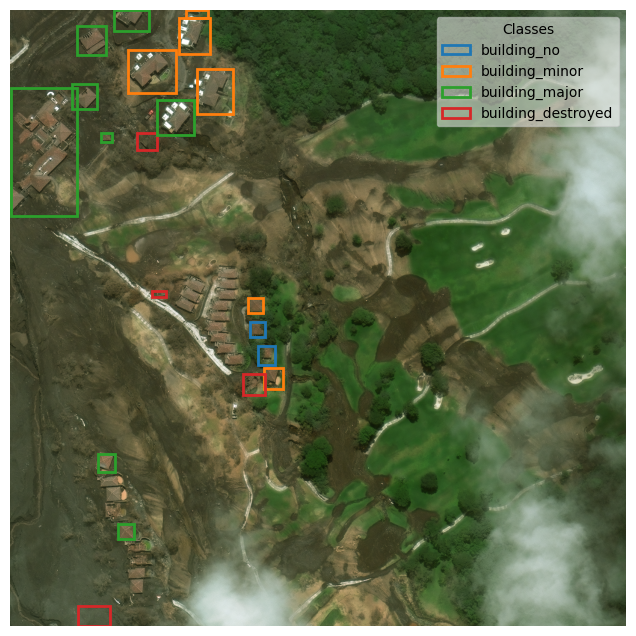

In [38]:
device = res.boxes.data.device
tensor = torch.tensor(gt_boxes, device=device)
res.boxes = Boxes(tensor, res.orig_shape)

# 1. Get the Boxes object from the YOLO result
boxes = res.boxes

# 2. Check if there are any detections
if boxes is None or boxes.data is None or boxes.data.shape[0] == 0:
    print("No boxes found.")
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(img_rgb)
    ax.axis("off")
    plt.show()

else:
    # 3. Prepare the figure
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(img_rgb)
    ax.axis("off")

    # 4. Use Colors instance to get consistent colors
    colors = Colors()

    # 5. Iterate through each box and draw
    for box in boxes.data:  # shape [x1, y1, x2, y2, conf, cls]
        x1, y1, x2, y2, conf, cls = box.tolist()
        cls = int(cls)
        color = custom_colors[cls]  # assumes custom_colors is a list or dict of matplotlib color strings

        rect = plt.Rectangle(
            (x1, y1), x2 - x1, y2 - y1,
            fill=False, linewidth=2, edgecolor=color
        )
        ax.add_patch(rect)

    # 6. Build the legend
    unique_classes = sorted(set([int(c.item()) for c in boxes.cls]))
    handles = []

    for cls in unique_classes:
        color = custom_colors[cls]
        name = model.names[cls]
        patch = mpatches.Patch(
            facecolor='none',
            edgecolor=color,
            linewidth=2,
            label=name
        )
        handles.append(patch)

    ax.legend(handles=handles, loc="upper right", title="Classes", framealpha=0.5)
    plt.show()

Patched conv 'model.0.conv' for 6-channel input.
No boxes found.


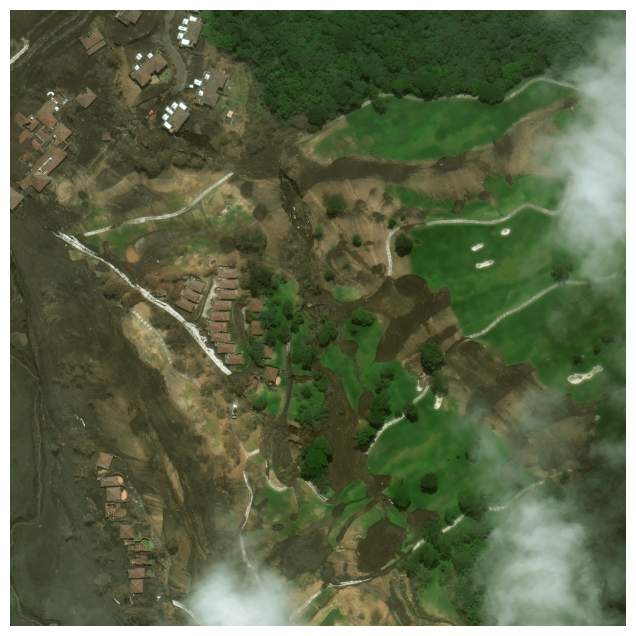

In [31]:
# MAIN - PREDICT + PLOT 2
import matplotlib.patches as mpatches
from matplotlib import colormaps as cm
from ultralytics.utils.plotting import Colors
import cv2
import torch
import torch.nn as nn
from ultralytics import YOLO
from ultralytics.engine.results import Boxes
import matplotlib.pyplot as plt

# --- Patch model stem to accept 6-channel inputs ---
def patch_first_conv_to_6ch(model_nn: nn.Module):
    for name, module in model_nn.named_modules():
        if isinstance(module, nn.Conv2d) and module.in_channels == 3:
            new_conv = nn.Conv2d(
                6, module.out_channels, module.kernel_size,
                stride=module.stride, padding=module.padding, bias=module.bias is not None
            )
            with torch.no_grad():
                new_conv.weight[:, :3] = module.weight
                new_conv.weight[:, 3:] = module.weight
            parent = model_nn
            for part in name.split('.')[:-1]:
                parent = getattr(parent, part)
            setattr(parent, name.split('.')[-1], new_conv)
            print(f"Patched conv '{name}' for 6-channel input.")
            return
    raise RuntimeError("No 3-channel Conv2d found.")

def stack_pre_post(pre_path, post_path, size=1024):
    pre = cv2.imread(pre_path)
    post = cv2.imread(post_path)

    pre = cv2.cvtColor(pre, cv2.COLOR_BGR2RGB)
    post = cv2.cvtColor(post, cv2.COLOR_BGR2RGB)

    pre = cv2.resize(pre, (size, size))
    post = cv2.resize(post, (size, size))

    pre_t = torch.from_numpy(pre).permute(2, 0, 1).float() / 255.0
    post_t = torch.from_numpy(post).permute(2, 0, 1).float() / 255.0

    img6 = torch.cat([pre_t, post_t], dim=0)  # (6, H, W)
    return img6.unsqueeze(0)  # Add batch dimension: (1, 6, H, W)

# Load your model (patching for 6-ch if you like, but not strictly needed for GT)
model = YOLO("runs/segment/train3/weights/best.pt")
patch_first_conv_to_6ch(model.model)
model.model.eval()

# Stack your (1,6,H,W) tensor
img6 = stack_pre_post(
    "/content/yolo_xbd/images/val/guatemala-volcano_00000004_pre_disaster.png",
    "/content/yolo_xbd/images/val/guatemala-volcano_00000004_post_disaster.png",
    size=1024
)
device = next(model.model.parameters()).device
img6 = img6.to(device)

# High-level predict (this will do NMS & give you .boxes/.masks)
with torch.no_grad():
    results = model.predict(source=img6, device=device, verbose=False)
res = results[0]  # a Results object

# Read the image (BGR→RGB) and note its size
img_bgr = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
h0, w0 = img_rgb.shape[:2]

# Choose a distinct color for each class, e.g. from a matplotlib colormap:
#    “tab10” has 10 distinct, colorblind-friendly hues.
cmap = cm.get_cmap("tab10")
# Suppose you have 4 classes (0–3):
custom_colors = { cls: cmap(cls/10)[:3]  # RGB in [0,1]
                  for cls in range(4) }

# Plot
# Get the Boxes object from the YOLO result
boxes = res.boxes

# Check if there are any detections
if boxes is None or boxes.data is None or boxes.data.shape[0] == 0:
    print("No boxes found.")
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(img_rgb)
    ax.axis("off")
    plt.show()

else:
    # Prepare the figure
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(img_rgb)
    ax.axis("off")

    # Use Colors instance to get consistent colors
    colors = Colors()

    # Iterate through each box and draw
    for box in boxes.data:  # shape [x1, y1, x2, y2, conf, cls]
        x1, y1, x2, y2, conf, cls = box.tolist()
        cls = int(cls)
        color = custom_colors[cls]  # assumes custom_colors is a list or dict of matplotlib color strings

        rect = plt.Rectangle(
            (x1, y1), x2 - x1, y2 - y1,
            fill=False, linewidth=2, edgecolor=color
        )
        ax.add_patch(rect)

    # Build the legend
    unique_classes = sorted(set([int(c.item()) for c in boxes.cls]))
    handles = []

    for cls in unique_classes:
        color = custom_colors[cls]
        name = model.names[cls]
        patch = mpatches.Patch(
            facecolor='none',
            edgecolor=color,
            linewidth=2,
            label=name
        )
        handles.append(patch)

    ax.legend(handles=handles, loc="upper right", title="Classes", framealpha=0.5)
    plt.show()

In [42]:
res

ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'building_no', 1: 'building_minor', 2: 'building_major', 3: 'building_destroyed'}
obb: None
orig_img: array([[[ 81, 101,  56,  77,  77,  55],
        [ 80,  99,  55,  68,  69,  48],
        [ 75,  97,  54,  68,  68,  47],
        ...,
        [198, 212, 210,  86, 109,  82],
        [199, 214, 211,  90, 112,  86],
        [199, 213, 211,  92, 114,  87]],

       [[ 83, 105,  58,  78,  78,  55],
        [ 81, 102,  57,  70,  70,  49],
        [ 75,  97,  54,  68,  68,  47],
        ...,
        [201, 216, 214,  84, 106,  80],
        [200, 215, 213,  86, 108,  81],
        [201, 216, 214,  94, 117,  90]],

       [[ 77, 100,  54,  78,  78,  56],
        [ 78, 101,  55,  71,  71,  50],
        [ 73,  97,  52,  63,  64,  43],
        ...,
        [197, 212, 210,  83, 106,  79],
        [198, 213, 211,  90, 113,  85],
        [198, 213, 210,  86, 